In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import os
# print(os.listdir("../input"))

In [3]:
train = pd.read_csv('train.csv',encoding='big5')

In [4]:
cols = ['id', '測項', '0', '1', '2', '3', '4', '5', '6', '7', '8']
test  = pd.read_csv('test.csv',names=cols,encoding='big5')

In [5]:
train.replace('NR','0',inplace=True)
test.replace('NR','0',inplace=True)

In [6]:
month_to_data = {}
for month in range(12):
    month_data = []
    for day in range(20):
        month_data.append(train.iloc[(month*20+day)*18:(month*20+day+1)*18,3:])
    month_to_data[month]=np.concatenate(month_data,axis=1)

In [7]:
train_x = []
train_y = []
for month in range(12):
    data = month_to_data[month]
    for i in range(471):
        train_x.append(data[:,i:i+9].reshape(-1))
        train_y.append(data[9,i+9])
train_x = np.array(train_x,dtype=float)
train_y = np.array(train_y,dtype=float)

In [8]:
test_x = []
for i in range(240):
    test_x.append(test.iloc[i*18:(i+1)*18,2:].values.reshape(-1))
test_x = np.array(test_x,dtype=float)

In [9]:
mean = train_x.mean(axis=0)
train_x -= mean
std = train_x.std(axis=0)
train_x /= std
test_x -= mean
test_x /= std

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
model = LinearRegression()
model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
pred = model.predict(test_x)

In [20]:
for i,it in enumerate(pred):
    if it < 0:
        pred[i] = 0

In [21]:
pred

array([  6.50979811,  18.18573981,  24.46054004,   7.67571975,
        27.13389991,  22.0859004 ,  23.65357332,  30.7694388 ,
        16.8893774 ,  59.53622691,  11.73546881,   9.34441886,
        63.26226829,  53.26509449,  22.04312015,  12.24586711,
        32.36908571,  66.65302871,   0.        ,  17.12506896,
        41.90579855,  72.35041747,   9.22489659,  17.97889774,
        14.69587415,  38.30336743,  14.92879991,  62.09218373,
         7.21941588,  55.5611298 ,  24.44116972,   8.69269523,
         2.5685008 ,  18.64668278,  27.59189414,  37.27481424,
        43.33900852,  29.63444783,  41.85149665,  35.42465247,
         7.77606655,  41.1526845 ,  30.42501668,  51.09276686,
        17.45657567,  35.47174022,  24.64471293,   9.69917163,
        26.59819723,  32.30614512,  20.28961123,   7.85571089,
        20.42478082,  52.57284466,  15.89627554,  36.19940096,
        33.11194221,  20.70137618,  57.33710228,  22.76218709,
        14.3062977 ,  41.82323728,  12.77676295,  48.54

In [22]:
np.savetxt('lr.csv',pred,delimiter=',')

In [28]:
from keras import models
from keras import layers
from keras import optimizers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(162,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])
    return model

In [30]:
from keras import backend as K
K.clear_session()

k = 4
num_val_samples = len(train_x) // k
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_x[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_y[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_x[:i * num_val_samples],
         train_x[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_y[:i * num_val_samples],
         train_y[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=64, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


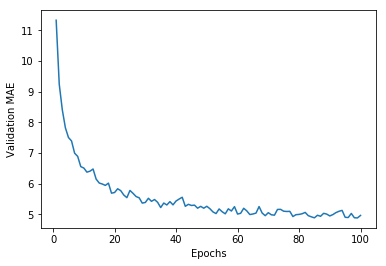

In [36]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [37]:
all_mae_histories

[[12.65505997913574,
  10.076764508333092,
  8.991433855665548,
  8.259734666018476,
  8.1457882696909,
  8.15789538988895,
  7.531602841273994,
  7.486684115491517,
  6.689180031281706,
  6.988348563343434,
  6.854490509627141,
  7.061267225099471,
  7.6557007335384775,
  6.791753915380436,
  6.176080811723951,
  6.117530921968432,
  6.158851450753398,
  6.894226220003359,
  5.815417221566084,
  6.015411052987328,
  6.329628679824904,
  6.3184785586422585,
  5.681763316921874,
  5.952598232288185,
  6.172255536300108,
  6.266648074539519,
  5.90704248918343,
  5.802212287919031,
  5.4299139028226575,
  5.419048080525328,
  6.095940735689394,
  5.703106100645288,
  6.22320040995064,
  5.603383534020426,
  5.203259580116785,
  5.5242505340144215,
  5.306062682165968,
  6.001977558095491,
  5.457934638750275,
  6.028495589470239,
  5.928076316849695,
  6.419063626159106,
  5.336450407375112,
  5.50255989539058,
  5.634174839621812,
  5.696010793428091,
  5.45465990202864,
  5.45574283937

In [ ]:
model = build_model()
hist = model.fit(train_x, train_y, epochs=400, batch_size=64, verbose=1)

Epoch 1/400
5652/5652 [==============================] - 3s 446us/step - loss: 435.0998 - mean_absolute_error: 15.7348
Epoch 2/400
5652/5652 [==============================] - 1s 225us/step - loss: 203.5473 - mean_absolute_error: 10.5703
Epoch 3/400
5652/5652 [==============================] - 1s 222us/step - loss: 167.9442 - mean_absolute_error: 9.5194
Epoch 4/400
5652/5652 [==============================] - 1s 228us/step - loss: 148.3692 - mean_absolute_error: 8.9812
Epoch 5/400
5652/5652 [==============================] - 1s 230us/step - loss: 138.6883 - mean_absolute_error: 8.5535
Epoch 6/400
5652/5652 [==============================] - 1s 235us/step - loss: 131.0321 - mean_absolute_error: 8.3645
Epoch 7/400
5652/5652 [==============================] - 1s 231us/step - loss: 120.3015 - mean_absolute_error: 8.1174
Epoch 8/400
5652/5652 [==============================] - 1s 223us/step - loss: 115.2991 - mean_absolute_error: 7.8497
Epoch 9/400
5652/5652 [==============================]

In [38]:
predict = model.predict(test_x)
print(predict)

[[  6.0852633]
 [ 17.464678 ]
 [ 27.565735 ]
 [ 11.598688 ]
 [ 27.207079 ]
 [ 22.39651  ]
 [ 22.555225 ]
 [ 30.793959 ]
 [ 16.314863 ]
 [ 53.943005 ]
 [ 13.742964 ]
 [ 11.282572 ]
 [ 61.04502  ]
 [ 49.077526 ]
 [ 22.972898 ]
 [ 12.958039 ]
 [ 29.508364 ]
 [ 68.43373  ]
 [  6.5883026]
 [ 16.625751 ]
 [ 41.201088 ]
 [ 70.09864  ]
 [  9.74538  ]
 [ 18.423218 ]
 [ 14.829647 ]
 [ 33.689297 ]
 [ 15.550478 ]
 [ 71.13483  ]
 [  7.4157534]
 [ 50.550797 ]
 [ 26.524792 ]
 [  9.626898 ]
 [  8.526613 ]
 [ 21.702477 ]
 [ 26.376345 ]
 [ 32.97175  ]
 [ 43.340183 ]
 [ 28.281551 ]
 [ 39.031487 ]
 [ 33.702335 ]
 [  8.685652 ]
 [ 42.101032 ]
 [ 28.867779 ]
 [ 48.752365 ]
 [ 17.826399 ]
 [ 33.588566 ]
 [ 23.750473 ]
 [ 11.440866 ]
 [ 24.25021  ]
 [ 29.73028  ]
 [ 21.364326 ]
 [  7.8964453]
 [ 22.190187 ]
 [ 50.64961  ]
 [ 16.545483 ]
 [ 31.764938 ]
 [ 30.791424 ]
 [ 23.018883 ]
 [ 55.98921  ]
 [ 22.800493 ]
 [ 16.576756 ]
 [ 39.186745 ]
 [ 14.726296 ]
 [ 46.44809  ]
 [ 13.84576  ]
 [ 13.9170685]
 [ 17.5414

In [43]:
np.savetxt('mlp.csv',predict.reshape(-1),delimiter=',')